In [52]:

import json
import os
from datetime import datetime

import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import torch
from einops import rearrange
import sys
sys.path.append(os.path.abspath("/Users/nisla/codigos/pangaea-bench/"))

from pangaea.datasets.base import RawGeoFMDataset
from pangaea.datasets.dummy import Dummy

In [54]:
data_test = Dummy(
    split="train",
    dataset_name="DUMMY",
    # multi_modal=True,
    multi_temporal=6,
    root_path="/Users/nisla/codigos/pangaea-bench/data/",
    classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9","10"],
    num_classes=11,
    ignore_index=0,
    img_size=128,
    multi_modal=False,
    bands={"S2": ["B01","B02", "B03", "B04", 
                  "B05", "B06", "B07", "B08",
                  "B8A", "B09", "B11", "B12"]},

    distribution=[0.92206, 0.03240, 0.01002, 0.00378, 0.00418, 0.00334, 0.01130, 0.00570, 0.00651, 0.00068, 0.00001],
    data_mean={"S2": [
        3788.9907, 3833.2418, 3845.4551, 3821.7418, 4088.3489, 4545.8299, 4710.7421, 4777.3250, 4913.6398, 5859.6192, 3485.5675, 3044.0120
    ]},

    data_std={"S2": [
        2761.6123, 2730.5804, 2529.2906, 2473.7932, 2393.5505, 2117.9953, 2051.6882, 1965.7810, 2157.3862, 3316.3806, 1284.9205, 1201.9167
    ]},
    data_min={"S2": [
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    ]},
    data_max={"S2": [
        17110, 20720, 19392, 18384, 17775, 17582, 17420, 17181, 17265, 16804, 16106, 16182
    ]},
    download_url="",
    auto_download=False,
    
)
# download(data_test)

Reading patch metadata . . .
Done.


In [55]:
len(data_test)


465

In [56]:
print(data_test[0]["image"]["S2"].shape)
print(data_test[0]["target"].shape)
print(data_test[0]["dates"]["S2"].shape)

torch.Size([12, 6, 128, 128])
torch.Size([128, 128])
torch.Size([6])


In [71]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Diccionario de especies y sus valores en la máscara

def examples(id_tile, temp, species):

    species_inv = {v: k for k, v in species.items()}



    img = data_test[id_tile]["image"]["S2"].numpy()
    target = data_test[id_tile]["target"].numpy()

    red = img[3, temp, :, :]
    green = img[2, temp, :, :]
    blue = img[1, temp, :, :]
    sentinel_rgb = np.stack([red, green, blue], axis=-1)

    def normalize(arr):
        arr = arr.astype(np.float32)
        vmin, vmax = np.percentile(arr, 2), np.percentile(arr, 98)
        arr = (arr - vmin) / (vmax - vmin)
        arr[arr < 0] = 0
        arr[arr > 1] = 1
        return arr

    sentinel_rgb_norm = normalize(sentinel_rgb)

    fig, ax = plt.subplots(1, 2, figsize=(15, 8))

    ax[0].imshow(sentinel_rgb_norm)
    ax[0].set_title("Tile Sentinel (RGB)")
    ax[0].axis("off")

    num_species = int(target.max())
    cmap_colors = ['white'] + [plt.cm.tab20(i) for i in range(num_species)]
    cmap = colors.ListedColormap(cmap_colors)
    bounds = list(range(num_species + 2))
    norm = colors.BoundaryNorm(bounds, cmap.N)

    im = ax[1].imshow(target, cmap=cmap, norm=norm)
    ax[1].set_title("Crop Raster")
    ax[1].axis("off")

    patches = [mpatches.Patch(color=cmap(i), label=species_inv[i]) for i in np.unique(target) if i in species_inv]
    ax[1].legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), title="Species")

    plt.tight_layout()
    plt.show()

species = np.load("/Users/nisla/codigos/pangaea-bench/data/species_to_val.npy", allow_pickle=True).item()
id_tile = 400
# id_tile = 65




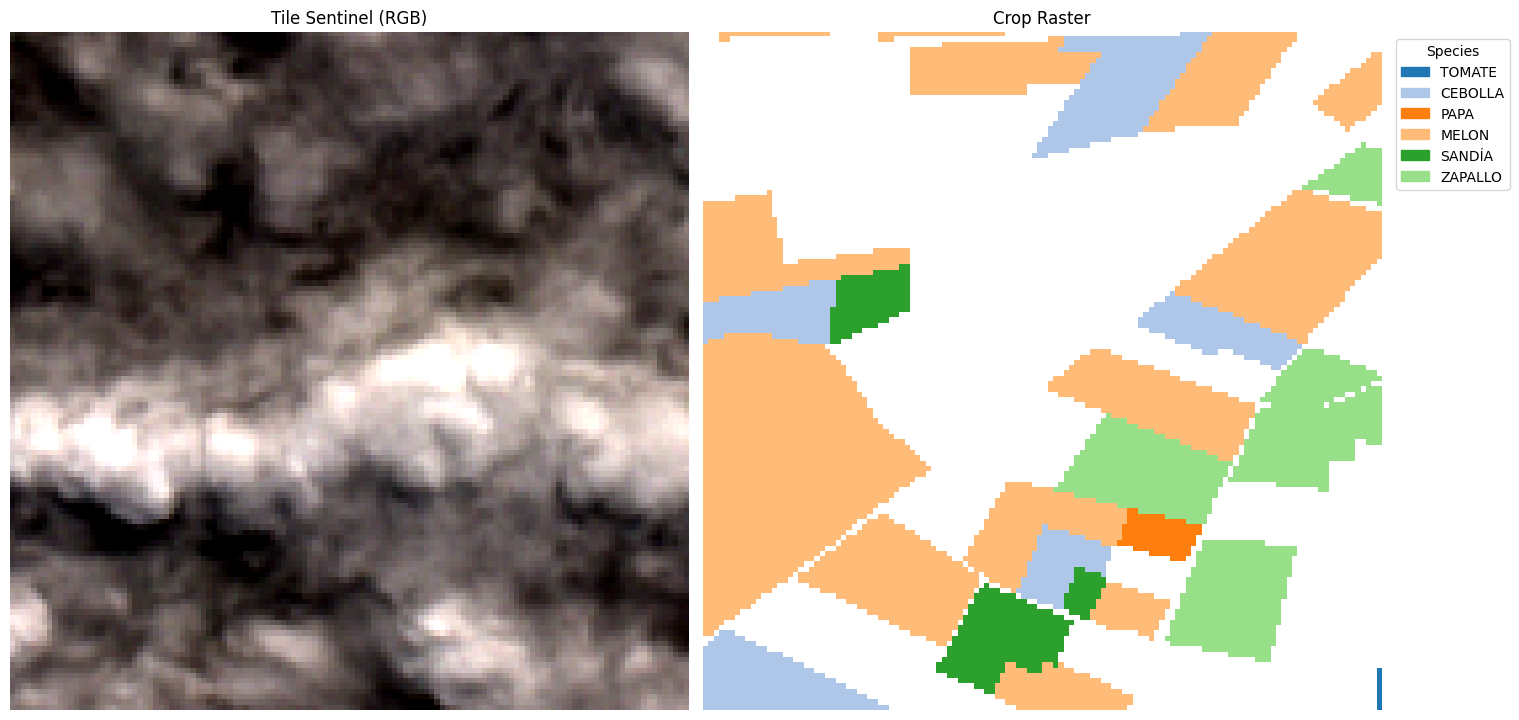

In [81]:
temp = 2
id_tile = 400

examples(id_tile, temp, species)

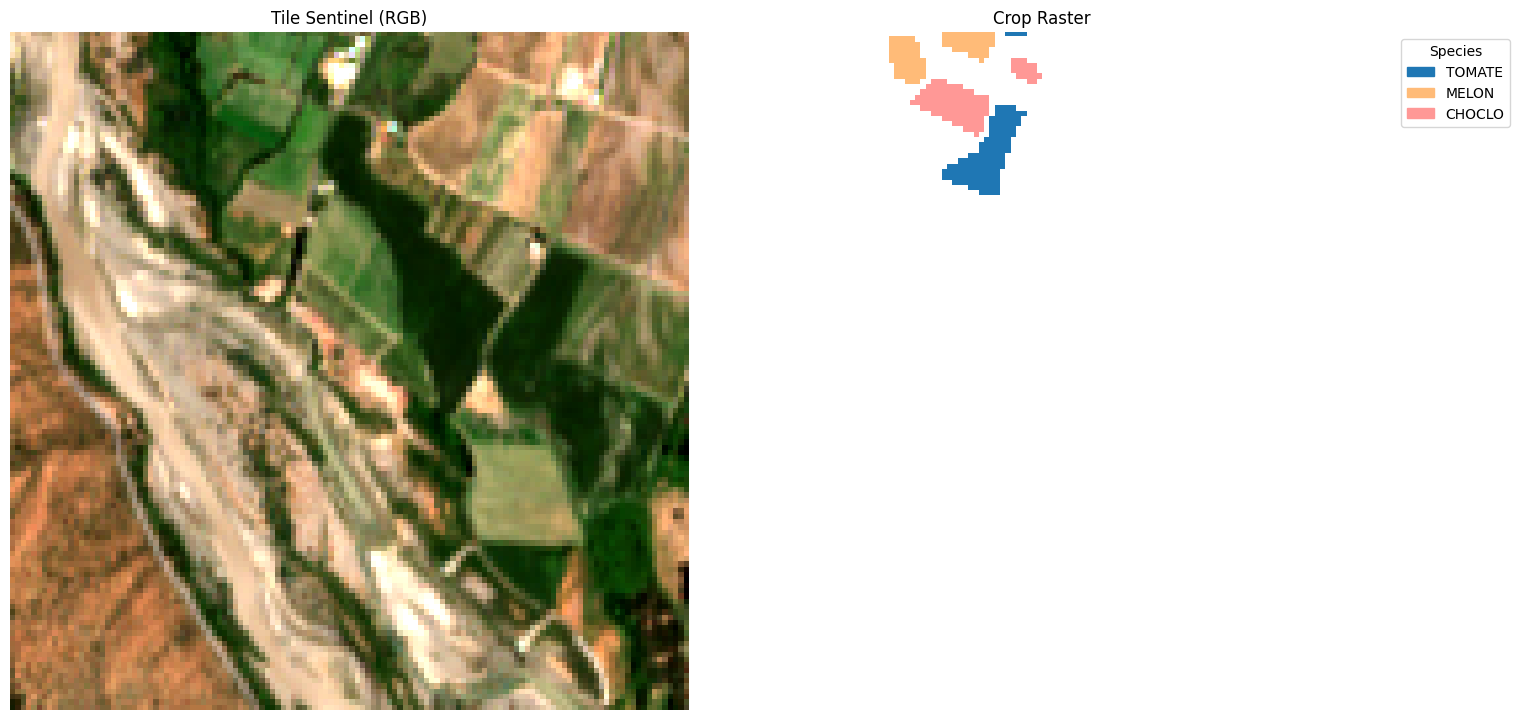

In [70]:
id_tile = 65

temp = 5
examples(id_tile, temp, species)


In [50]:
# read metadata geojson
metadata = gpd.read_file("/Users/nisla/codigos/pangaea-bench/data/metadata.geojson")
metadata_orig = gpd.read_file("/Users/nisla/codigos/pangaea-bench/jupyter/metadata.geojson")


In [49]:
metadata

,id,tile,dates-S2,Parcel_Cover,Fold,geometry
0,10000,T19HCB,"{ ""0"": ""20170827"", ""1"": ""20171006"", ""2"": ""2017...",0.001587,1,"POLYGON ((315360 6200020, 315360 6192340, 3076..."
1,10001,T19HCB,"{ ""0"": ""20170827"", ""1"": ""20171006"", ""2"": ""2017...",0.038330,2,"POLYGON ((346080 6200020, 346080 6192340, 3384..."
2,10002,T19HCB,"{ ""0"": ""20170827"", ""1"": ""20171006"", ""2"": ""2017...",0.011536,3,"POLYGON ((399840 6200020, 399840 6192340, 3921..."
3,10003,T19HCB,"{ ""0"": ""20170827"", ""1"": ""20171006"", ""2"": ""2017...",0.196777,4,"POLYGON ((407520 6200020, 407520 6192340, 3998..."
4,10004,T19HCB,"{ ""0"": ""20170827"", ""1"": ""20171006"", ""2"": ""2017...",0.417664,5,"POLYGON ((415200 6200020, 415200 6192340, 4075..."
...,...,...,...,...,...,...
770,20413,T19HCC,"{ ""0"": ""20170827"", ""1"": ""20171006"", ""2"": ""2017...",0.205937,1,"POLYGON ((461280 5647240, 461280 5639560, 4536..."
771,20414,T19HCC,"{ ""0"": ""20170827"", ""1"": ""20171006"", ""2"": ""2017...",0.123438,2,"POLYGON ((468960 5647240, 468960 5639560, 4612..."
772,20415,T19HCC,"{ ""0"": ""20170827"", ""1"": ""20171006"", ""2"": ""2017...",0.019375,3,"POLYGON ((476640 5647240, 476640 5639560, 4689..."
773,20416,T19HCC,"{ ""0"": ""20170827"", ""1"": ""20171006"", ""2"": ""2017...",0.076172,4,"POLYGON ((492000 5647240, 492000 5639560, 4843..."


In [51]:
metadata_orig

,Fold,ID_PATCH,N_Parcel,Parcel_Cover,TILE,dates-S1A,dates-S1D,dates-S2,id,geometry
0,1,10000,119,0.808032,t30uxv,"{ ""0"": 20181004, ""1"": 20181010, ""2"": 20181016,...","{ ""0"": 20181002, ""1"": 20181008, ""2"": 20181014,...","{ ""0"": 20180924, ""1"": 20180929, ""2"": 20181004,...",10000,"MULTIPOLYGON (((391504.736 6956805.915, 392781..."
1,2,10001,111,0.501986,t30uxv,"{ ""0"": 20181004, ""1"": 20181010, ""2"": 20181016,...","{ ""0"": 20181002, ""1"": 20181008, ""2"": 20181014,...","{ ""0"": 20180924, ""1"": 20180929, ""2"": 20181004,...",10001,"MULTIPOLYGON (((367628.562 6880296.822, 368905..."
2,4,10002,131,0.638722,t30uxv,"{ ""0"": 20181004, ""1"": 20181010, ""2"": 20181016,...","{ ""0"": 20181002, ""1"": 20181008, ""2"": 20181014,...","{ ""0"": 20180924, ""1"": 20180929, ""2"": 20181004,...",10002,"MULTIPOLYGON (((388950.375 6957003.181, 390227..."
3,5,10003,75,0.866824,t30uxv,"{ ""0"": 20181004, ""1"": 20181010, ""2"": 20181016,...","{ ""0"": 20181002, ""1"": 20181008, ""2"": 20181014,...","{ ""0"": 20180924, ""1"": 20180929, ""2"": 20181004,...",10003,"MULTIPOLYGON (((455228.326 6917189.74, 456504...."
4,4,10004,46,0.204906,t30uxv,"{ ""0"": 20181004, ""1"": 20181010, ""2"": 20181016,...","{ ""0"": 20181002, ""1"": 20181008, ""2"": 20181014,...","{ ""0"": 20180924, ""1"": 20180929, ""2"": 20181004,...",10004,"MULTIPOLYGON (((364779.509 6910052.243, 366056..."
...,...,...,...,...,...,...,...,...,...,...
2428,2,40558,33,0.783991,t32ulu,"{ ""0"": 20181002, ""1"": 20181008, ""2"": 20181014,...","{ ""0"": 20181006, ""1"": 20181012, ""2"": 20181018,...","{ ""0"": 20180917, ""1"": 20180922, ""2"": 20180927,...",40558,"MULTIPOLYGON (((977680.878 6836058.796, 978956..."
2429,5,40559,24,0.129896,t32ulu,"{ ""0"": 20181002, ""1"": 20181008, ""2"": 20181014,...","{ ""0"": 20181006, ""1"": 20181012, ""2"": 20181018,...","{ ""0"": 20180917, ""1"": 20180922, ""2"": 20180927,...",40559,"MULTIPOLYGON (((1018204.4 6759608.309, 1019480..."
2430,3,40560,7,0.255358,t32ulu,"{ ""0"": 20181002, ""1"": 20181008, ""2"": 20181014,...","{ ""0"": 20181006, ""1"": 20181012, ""2"": 20181018,...","{ ""0"": 20180917, ""1"": 20180922, ""2"": 20180927,...",40560,"MULTIPOLYGON (((1007714.487 6812700.875, 10089..."
2431,3,40561,5,0.054305,t32ulu,"{ ""0"": 20181002, ""1"": 20181008, ""2"": 20181014,...","{ ""0"": 20181006, ""1"": 20181012, ""2"": 20181018,...","{ ""0"": 20180917, ""1"": 20180922, ""2"": 20180927,...",40561,"MULTIPOLYGON (((1002310.153 6766088.52, 100358..."
